In [37]:
import pandas as pd
import numpy as np
import time
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
File_Path = '/content/london_weather.csv'

In [38]:
class Preprocessing:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.scaler = None
        self.normalized_data = None
        self.train_size = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.T = 20  # Number of timesteps to look while predicting

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        return self.data

    def clean_data(self):
        # Convert date to datetime format
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Drop rows with any NaN values
        self.data.dropna(inplace=True)

        return self.data

    def prepare_data_for_model(self, train_ratio=0.8, target_column='mean_temp'):
        # Separate features and target
        input_data = self.data.drop(['date'], axis=1)
        targets = self.data[target_column].values

        # Define dimensions
        D = input_data.shape[1]  # Number of features
        N = len(input_data) - self.T

        # Calculate train size
        self.train_size = int(len(input_data) * train_ratio)

        # Normalize input data
        self.scaler = StandardScaler()
        self.scaler.fit(input_data[:self.train_size + self.T - 1])
        self.normalized_data = self.scaler.transform(input_data)

        # Prepare X_train and y_train
        self.X_train = np.zeros((self.train_size, self.T, D))
        self.y_train = np.zeros((self.train_size, 1))

        for t in range(self.train_size):
            self.X_train[t, :, :] = self.normalized_data[t:t+self.T]
            self.y_train[t] = targets[t+self.T]

        # Prepare X_test and y_test
        self.X_test = np.zeros((N - self.train_size, self.T, D))
        self.y_test = np.zeros((N - self.train_size, 1))

        for i in range(N - self.train_size):
            t = i + self.train_size
            self.X_test[i, :, :] = self.normalized_data[t:t+self.T]
            self.y_test[i] = targets[t+self.T]

        # Convert to PyTorch tensors
        self.X_train = torch.from_numpy(self.X_train.astype(np.float32))
        self.y_train = torch.from_numpy(self.y_train.astype(np.float32))
        self.X_test = torch.from_numpy(self.X_test.astype(np.float32))
        self.y_test = torch.from_numpy(self.y_test.astype(np.float32))

        return self.X_train, self.y_train, self.X_test, self.y_test

    def get_train_test_data(self):
        return self.X_train, self.y_train, self.X_test, self.y_test

    def get_original_data(self):
        return self.data

    def get_scaler(self):
        return self.scaler


In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.M = hidden_dim
        self.L = layer_dim

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True
        )
        # batch_first to have (batch_dim, seq_dim, feature_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        # Set device - ideally this would be a class property set during initialization
        device = X.device

        # Initial hidden state and cell state
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

        # h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [40]:
class Training:
    def __init__(self):
        self.model = None
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_losses = None
        self.test_losses = None

    def create_model(self, input_dim, hidden_dim=512, layer_dim=2, output_dim=1):
        self.model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
        self.model.to(self.device)
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=200):
        # Move data to device
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)

        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate,
            momentum=0.9,
            weight_decay=1e-4
        )

        self.train_losses = np.zeros(epochs)
        self.test_losses = np.zeros(epochs)

        for epoch in range(epochs):
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(X_train)
            loss = criterion(outputs, y_train)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Train loss
            self.train_losses[epoch] = loss.item()

            # Test loss
            test_outputs = self.model(X_test)
            test_loss = criterion(test_outputs, y_test)
            self.test_losses[epoch] = test_loss.item()

        return self.train_losses, self.test_losses

    def load_model(self, model_path=None, weights_path=None):
        if model_path is not None:
            self.model = torch.load(model_path, map_location=self.device)
        elif weights_path is not None and self.model is not None:
            self.model.load_state_dict(torch.load(weights_path, map_location=self.device))

        return self.model

    def get_model(self):
        return self.model

    def get_losses(self):
        return self.train_losses, self.test_losses

In [41]:
class Inference:
    def __init__(self, model=None, device=None):
        self.model = model
        self.device = device if device is not None else torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu"
        )
        self.predictions = None

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)

    def predict(self, X_test):
        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Generate predictions
        self.predictions = []
        with torch.no_grad():
            for i in range(len(X_test)):
                input_ = X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])
                p = self.model(input_)[0, 0].item()
                self.predictions.append(p)
        return self.predictions

    def get_predictions(self):
        return self.predictions

In [42]:
class Analysis:
    def __init__(self):
        self.true_values = None
        self.predictions = None
        self.metrics = {}

    def set_data(self, true_values, predictions):
        if isinstance(true_values, torch.Tensor):
            self.true_values = true_values.cpu().detach().numpy()
        else:
            self.true_values = true_values

        self.predictions = predictions

    def calculate_metrics(self):
        if self.true_values is None or self.predictions is None:
            raise ValueError("Data not set. Call set_data first.")

        # Calculate MAE
        self.metrics['MAE'] = mean_absolute_error(self.true_values, self.predictions)

        # Calculate MSE
        self.metrics['MSE'] = mean_squared_error(self.true_values, self.predictions)

        # Calculate RMSE
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])

        print(f"Metrics calculated - MAE: {self.metrics['MAE']:.3f}, MSE: {self.metrics['MSE']:.3f}, RMSE: {self.metrics['RMSE']:.3f}")
        return self.metrics

    def analyze_error_distribution(self):
        # Calculate errors
        errors = self.true_values.flatten() - np.array(self.predictions)

        # Basic statistics of errors
        error_stats = {
            'mean': np.mean(errors),
            'std': np.std(errors),
            'min': np.min(errors),
            'max': np.max(errors)
        }

        print(f"Error statistics - Mean: {error_stats['mean']:.3f}, Std: {error_stats['std']:.3f}, Min: {error_stats['min']:.3f}, Max: {error_stats['max']:.3f}")
        return errors, error_stats

    def get_metrics(self):
        return self.metrics

In [43]:
class Display:
    def __init__(self):
        self.data = None
        self.predictions = None
        self.dates = None
        self.plot_df = None
        self.test_target = None
        self.test_predictions = None

    def set_data(self, original_data, predictions, start_idx=None):
        self.data = original_data
        self.predictions = predictions

        # Prepare the plot DataFrame
        plot_len = len(predictions)
        if start_idx is None:
            start_idx = -plot_len

        self.plot_df = original_data[['date', 'mean_temp']].copy(deep=True)
        self.plot_df = self.plot_df.iloc[start_idx:]
        self.plot_df['prediction'] = predictions
        self.plot_df.set_index('date', inplace=True)

    def set_test_data(self, test_target, test_predictions):
        # For storing test data for LSTM error analysis
        self.test_target = test_target
        self.test_predictions = test_predictions

        # Show sample of prediction dataframe
        print("Sample of prediction dataframe:")
        print(self.plot_df.head(5))

        # Display years in dataset
        years = self.plot_df.index.year.unique()
        print(f"Years in the dataset: {years}")

    def plot_results(self, title=None, figsize=(20, 10)):
        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
        plt.plot(self.plot_df['prediction'], label='Predicted Temperature', linewidth=1)
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='lower right')

        if title:
            plt.title(title)

        plt.tight_layout()
        plt.show()

    def plot_by_year(self, figsize=(20, 10)):
        # Group data by year
        plot_df_by_years = []
        for y in self.plot_df.index.year.unique():
            plot_df_by_years.append((y, self.plot_df.loc[self.plot_df.index.year == y]))

        # Plot each year separately
        for year, year_df in plot_df_by_years:
            plt.figure(figsize=figsize)
            plt.plot(year_df['mean_temp'], label='Actual Temperature', linewidth=1)
            plt.plot(year_df['prediction'], label='One-step Prediction', linewidth=1)
            plt.xlabel('Date')
            plt.ylabel('Temperature (°C)')
            plt.legend(loc='lower right')
            plt.title(f'Temperature in {year}')
            plt.tight_layout()
            plt.show()

    def plot_error_histogram(self, errors, bins=25, figsize=(12, 8)):
        plt.figure(figsize=figsize)
        plt.hist(errors, bins=bins)
        plt.xlabel('Temperature Difference (Actual - Predicted)')
        plt.ylabel('Count')
        plt.title('Distribution of Prediction Errors')
        plt.tight_layout()
        plt.show()

    def plot_training_history(self, train_losses, test_losses, figsize=(12, 8)):
        plt.figure(figsize=figsize)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch No')  # Changed from 'Epoch' to 'Epoch No' as requested
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.tight_layout()
        plt.show()

    def plot_one_step_predictions(self, figsize=(25, 10)):
        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
        plt.plot(self.plot_df['prediction'], label='One-step Prediction', linewidth=1)
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='lower right')
        plt.title('Actual vs Predicted Temperature')
        plt.show()

    def analyze_lstm_error(self):
        if self.test_target is None or self.test_predictions is None:
            raise ValueError("Test data not set. Call set_test_data first.")

        # Create error analysis dataframe
        LTSM_error = pd.DataFrame(self.test_target.flatten(), columns=['targets'])
        LTSM_error['predictions'] = self.test_predictions
        LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
        LTSM_error['error_square'] = LTSM_error['error'] ** 2
        err = LTSM_error['error_square'].mean()
        print(f'Mean square error is: {err:.3f}')

        # Plot error histogram
        plt.figure(figsize=(12, 8))
        plt.hist(LTSM_error['error'], bins=25)
        plt.xlabel('Temperature Difference (real - predicted)')
        plt.ylabel('Count')
        plt.title('Distribution of Differences')
        plt.show()

        return LTSM_error, err

In [44]:
# Constants
CAPACITY = 15  # Size of the shared buffer
DATALOADER_LOAD_THRESHOLD = 1  # Number of datapoints to load at once
TRAINER_READ_THRESHOLD = 3  # Number of datapoints trainer reads at once
INFERER_READ_THRESHOLD = 1  # Number of datapoints inferer reads at once

# Simulated processing times
DATALOADER_WAIT_TIME = 1  # seconds
TRAINER_WAIT_TIME = 5  # seconds
INFERER_WAIT_TIME = 2  # seconds

# File path for the dataset
FILE_PATH = '/content/london_weather.csv'

# Set random seed for reproducibility
random.seed(0)

# Create a shared buffer for data
data_buffer = [None for _ in range(CAPACITY)]

print('[CONSOLE] Operation started.')
main_start_time = time.time()

[CONSOLE] Operation started.


In [45]:
# Preprocess start time
preprocess_start_time = time.time()

# Initialize preprocessing
preprocessor = Preprocessing(FILE_PATH)
preprocessor.load_data()
preprocessor.clean_data()
X_train, y_train, X_test, y_test = preprocessor.prepare_data_for_model(target_column='mean_temp')

# Fill the buffer with batches (using mini-batches from training data)
datapoints_loaded = 0
in_index = 0

# Calculate batch size to divide the data into CAPACITY chunks
batch_size = max(1, len(X_train) // CAPACITY)

while datapoints_loaded < CAPACITY:
    # Create a batch
    start_idx = datapoints_loaded * batch_size
    end_idx = min(start_idx + batch_size, len(X_train))

    if start_idx >= len(X_train):
        break

    # Get a batch of data
    batch_X = X_train[start_idx:end_idx]
    batch_y = y_train[start_idx:end_idx]

    # Add to buffer
    data_buffer[in_index] = (batch_X, batch_y)
    print(f"Loader added datapoint batch to data index: {in_index + 1}, batch size: {len(batch_X)}")

    # Update indices
    in_index = (in_index + DATALOADER_LOAD_THRESHOLD) % CAPACITY
    datapoints_loaded += DATALOADER_LOAD_THRESHOLD

    # Simulate processing time
    time.sleep(DATALOADER_WAIT_TIME)

preprocess_end_time = time.time()
print(f"Loader has taken {preprocess_end_time - preprocess_start_time:.2f} seconds to complete")

Loader added datapoint batch to data index: 1, batch size: 813
Loader added datapoint batch to data index: 2, batch size: 813
Loader added datapoint batch to data index: 3, batch size: 813
Loader added datapoint batch to data index: 4, batch size: 813
Loader added datapoint batch to data index: 5, batch size: 813
Loader added datapoint batch to data index: 6, batch size: 813
Loader added datapoint batch to data index: 7, batch size: 813
Loader added datapoint batch to data index: 8, batch size: 813
Loader added datapoint batch to data index: 9, batch size: 813
Loader added datapoint batch to data index: 10, batch size: 813
Loader added datapoint batch to data index: 11, batch size: 813
Loader added datapoint batch to data index: 12, batch size: 813
Loader added datapoint batch to data index: 13, batch size: 813
Loader added datapoint batch to data index: 14, batch size: 813
Loader added datapoint batch to data index: 15, batch size: 813
Loader has taken 15.06 seconds to complete


In [46]:
# Training start time
training_start_time = time.time()

# Initialize trainer and create model
trainer = Training()
input_dim = X_train.shape[2]  # Number of features
model = trainer.create_model(input_dim=input_dim)

# Read data from buffer in chunks
read_datapoints_in_trainer = 0
out_index_trainer = 0

# Store loss values
all_train_losses = []
all_test_losses = []

while read_datapoints_in_trainer < CAPACITY:
    if out_index_trainer >= datapoints_loaded:
        break

    # Collect data chunks for training
    trainer_data_to_load = []
    trainer_targets_to_load = []

    # Read TRAINER_READ_THRESHOLD batches (or until end of data)
    for i in range(out_index_trainer, min(out_index_trainer + TRAINER_READ_THRESHOLD, datapoints_loaded)):
        batch_X, batch_y = data_buffer[i]
        trainer_data_to_load.append(batch_X)
        trainer_targets_to_load.append(batch_y)

    # Combine batches if we have more than one
    if len(trainer_data_to_load) > 1:
        combined_X = torch.cat(trainer_data_to_load)
        combined_y = torch.cat(trainer_targets_to_load)
    else:
        combined_X = trainer_data_to_load[0]
        combined_y = trainer_targets_to_load[0]

    print(f"Trainer read datapoints from indices: {out_index_trainer + 1} to {min(out_index_trainer + TRAINER_READ_THRESHOLD, datapoints_loaded)}")

    # Train on the combined batch
    train_losses, test_losses = trainer.train_model(
        combined_X, combined_y,
        X_test[:100], y_test[:100],  # Use subset of test data for validation
        learning_rate=0.01,
        epochs=100  # Use fewer epochs for demonstration
    )

    # Store losses for plotting
    all_train_losses.extend(train_losses)
    all_test_losses.extend(test_losses)

    # Simulate processing time
    time.sleep(TRAINER_WAIT_TIME)

    # Update indices
    out_index_trainer = (out_index_trainer + TRAINER_READ_THRESHOLD) % CAPACITY
    read_datapoints_in_trainer += TRAINER_READ_THRESHOLD

training_end_time = time.time()
print(f"Trainer has taken {training_end_time - training_start_time:.2f} seconds to complete")

Trainer read datapoints from indices: 1 to 3
Trainer read datapoints from indices: 4 to 6
Trainer read datapoints from indices: 7 to 9
Trainer read datapoints from indices: 10 to 12
Trainer read datapoints from indices: 13 to 15
Trainer has taken 182.49 seconds to complete


In [47]:
# Inference start time
inference_start_time = time.time()

# Initialize inference with the trained model
inference = Inference()
inference.set_model(model)

# Move model and test data to cuda:0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Get dimensions for reshaping
T = X_test.shape[1]  # Number of timesteps
D = X_test.shape[2]  # Number of features

# Generate one-step predictions for all test data
test_target = y_test.cpu().detach().numpy()  # Only move to CPU for numpy conversion
test_predictions = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    for i in range(len(X_test)):
        input_ = X_test[i].reshape(1, T, D).to(device)  # Ensure the input is on cuda:0
        p = model(input_)[0, 0].item()
        test_predictions.append(p)

# Also use a limited number of test samples for original inference logic
read_datapoints_in_inferer = 0
out_index_inferer = 0
all_predictions = []
max_samples = min(CAPACITY, len(X_test))

while read_datapoints_in_inferer < max_samples:
    # Get test example
    test_sample = X_test[out_index_inferer:out_index_inferer+1]

    # Make prediction
    prediction = test_predictions[out_index_inferer]
    all_predictions.append(prediction)

    print(f"Inferer read datapoint from data index: {out_index_inferer + 1}")

    # Simulate processing time
    time.sleep(INFERER_WAIT_TIME)

    # Update indices
    out_index_inferer += INFERER_READ_THRESHOLD
    read_datapoints_in_inferer += INFERER_READ_THRESHOLD

inference_end_time = time.time()
print(f"Inferer has taken {inference_end_time - inference_start_time:.2f} seconds to complete")

Inferer read datapoint from data index: 1
Inferer read datapoint from data index: 2
Inferer read datapoint from data index: 3
Inferer read datapoint from data index: 4
Inferer read datapoint from data index: 5
Inferer read datapoint from data index: 6
Inferer read datapoint from data index: 7
Inferer read datapoint from data index: 8
Inferer read datapoint from data index: 9
Inferer read datapoint from data index: 10
Inferer read datapoint from data index: 11
Inferer read datapoint from data index: 12
Inferer read datapoint from data index: 13
Inferer read datapoint from data index: 14
Inferer read datapoint from data index: 15
Inferer has taken 33.50 seconds to complete


Sample of prediction dataframe:
            mean_temp  prediction
date                             
2012-08-27       16.9   18.059662
2012-08-28       19.1   19.233566
2012-08-29       17.1   17.440369
2012-08-30       15.7   15.425801
2012-08-31       12.4   15.442137
Years in the dataset: Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int32', name='date')


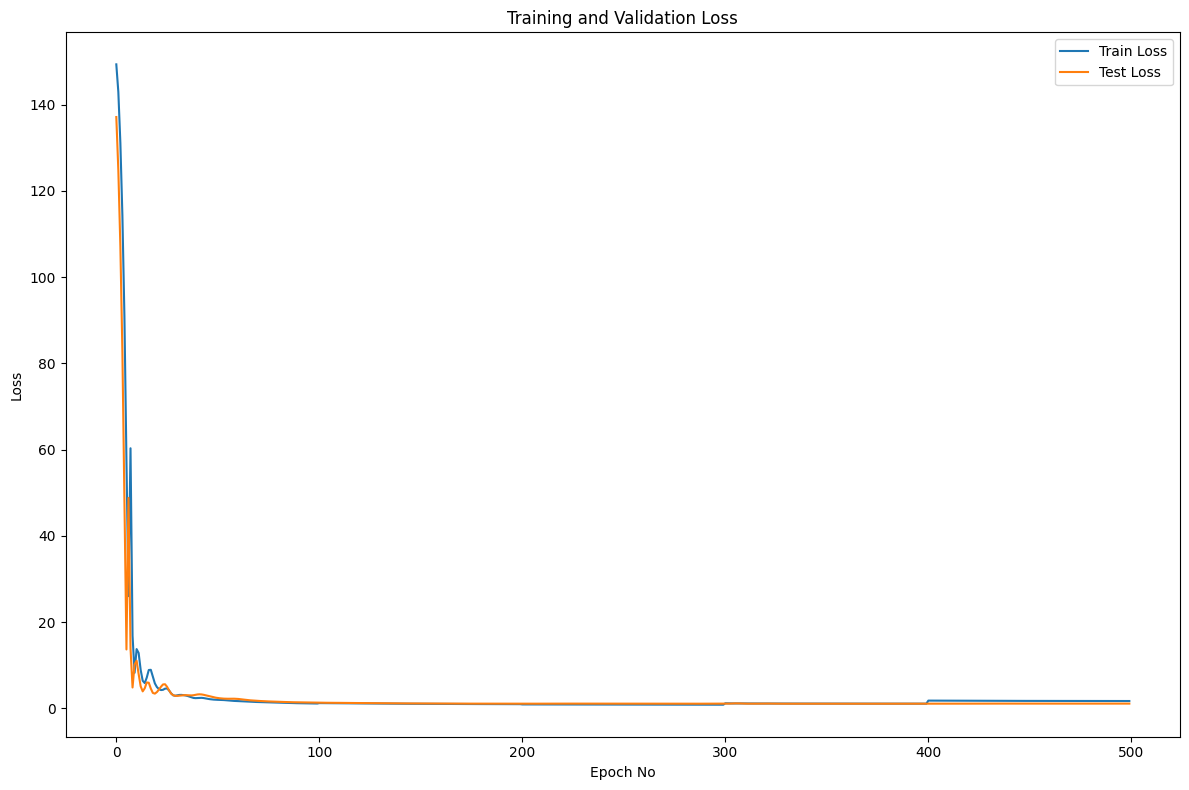

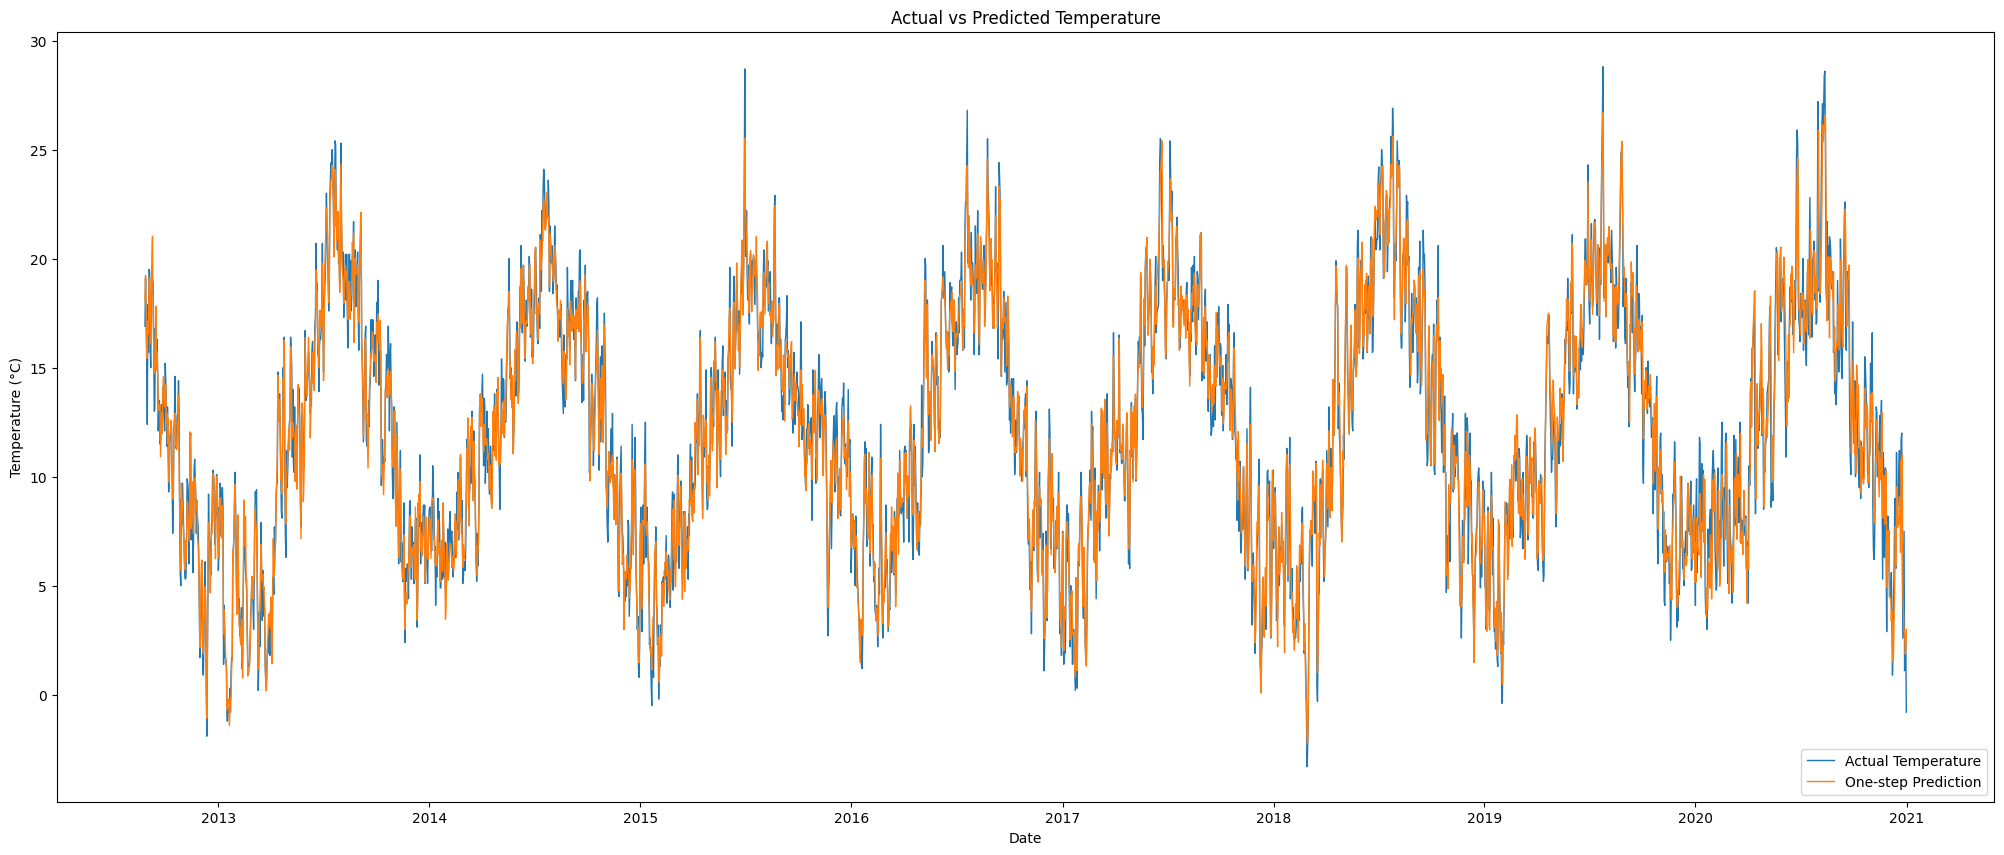

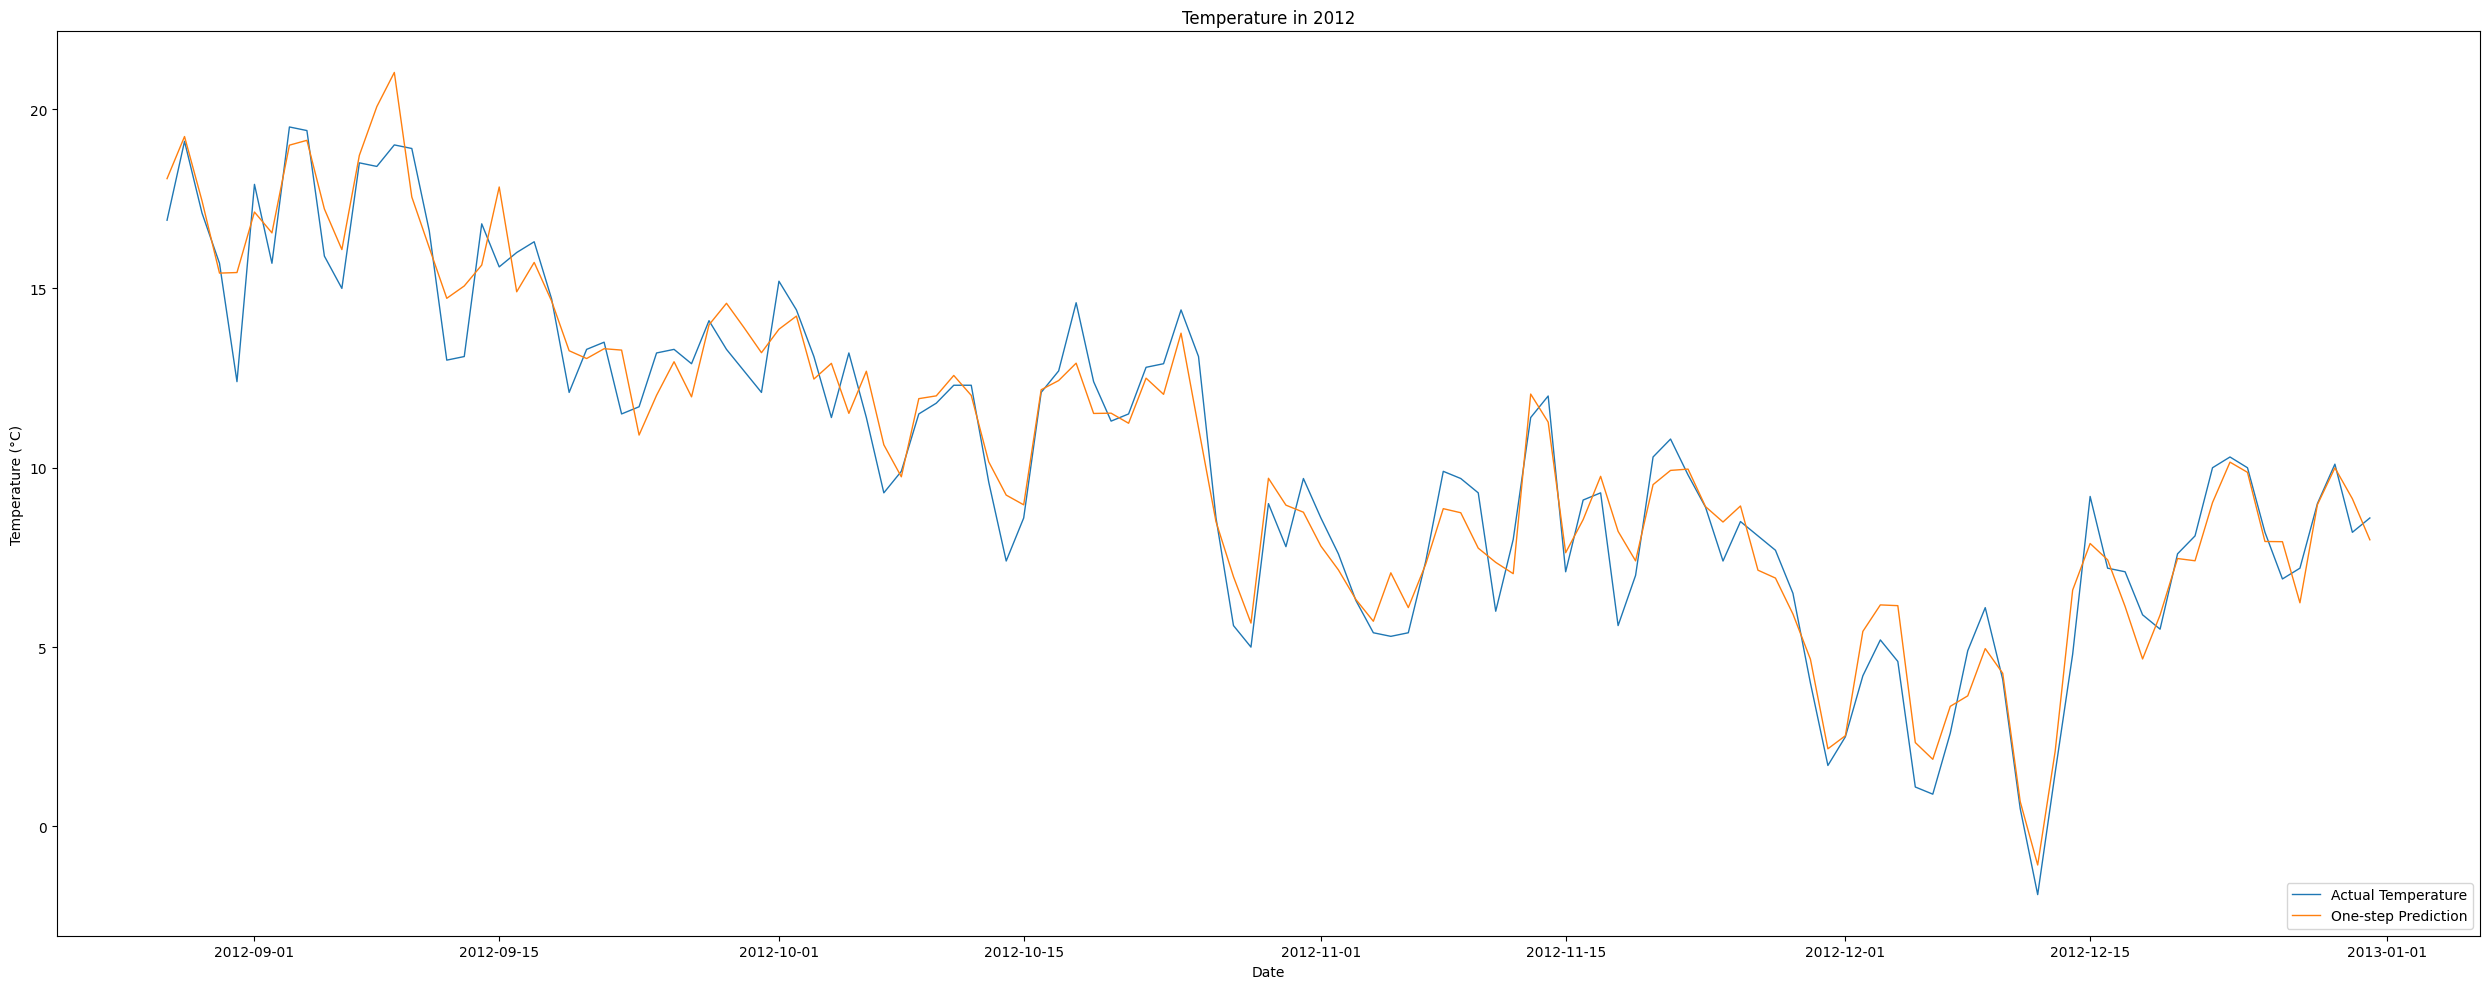

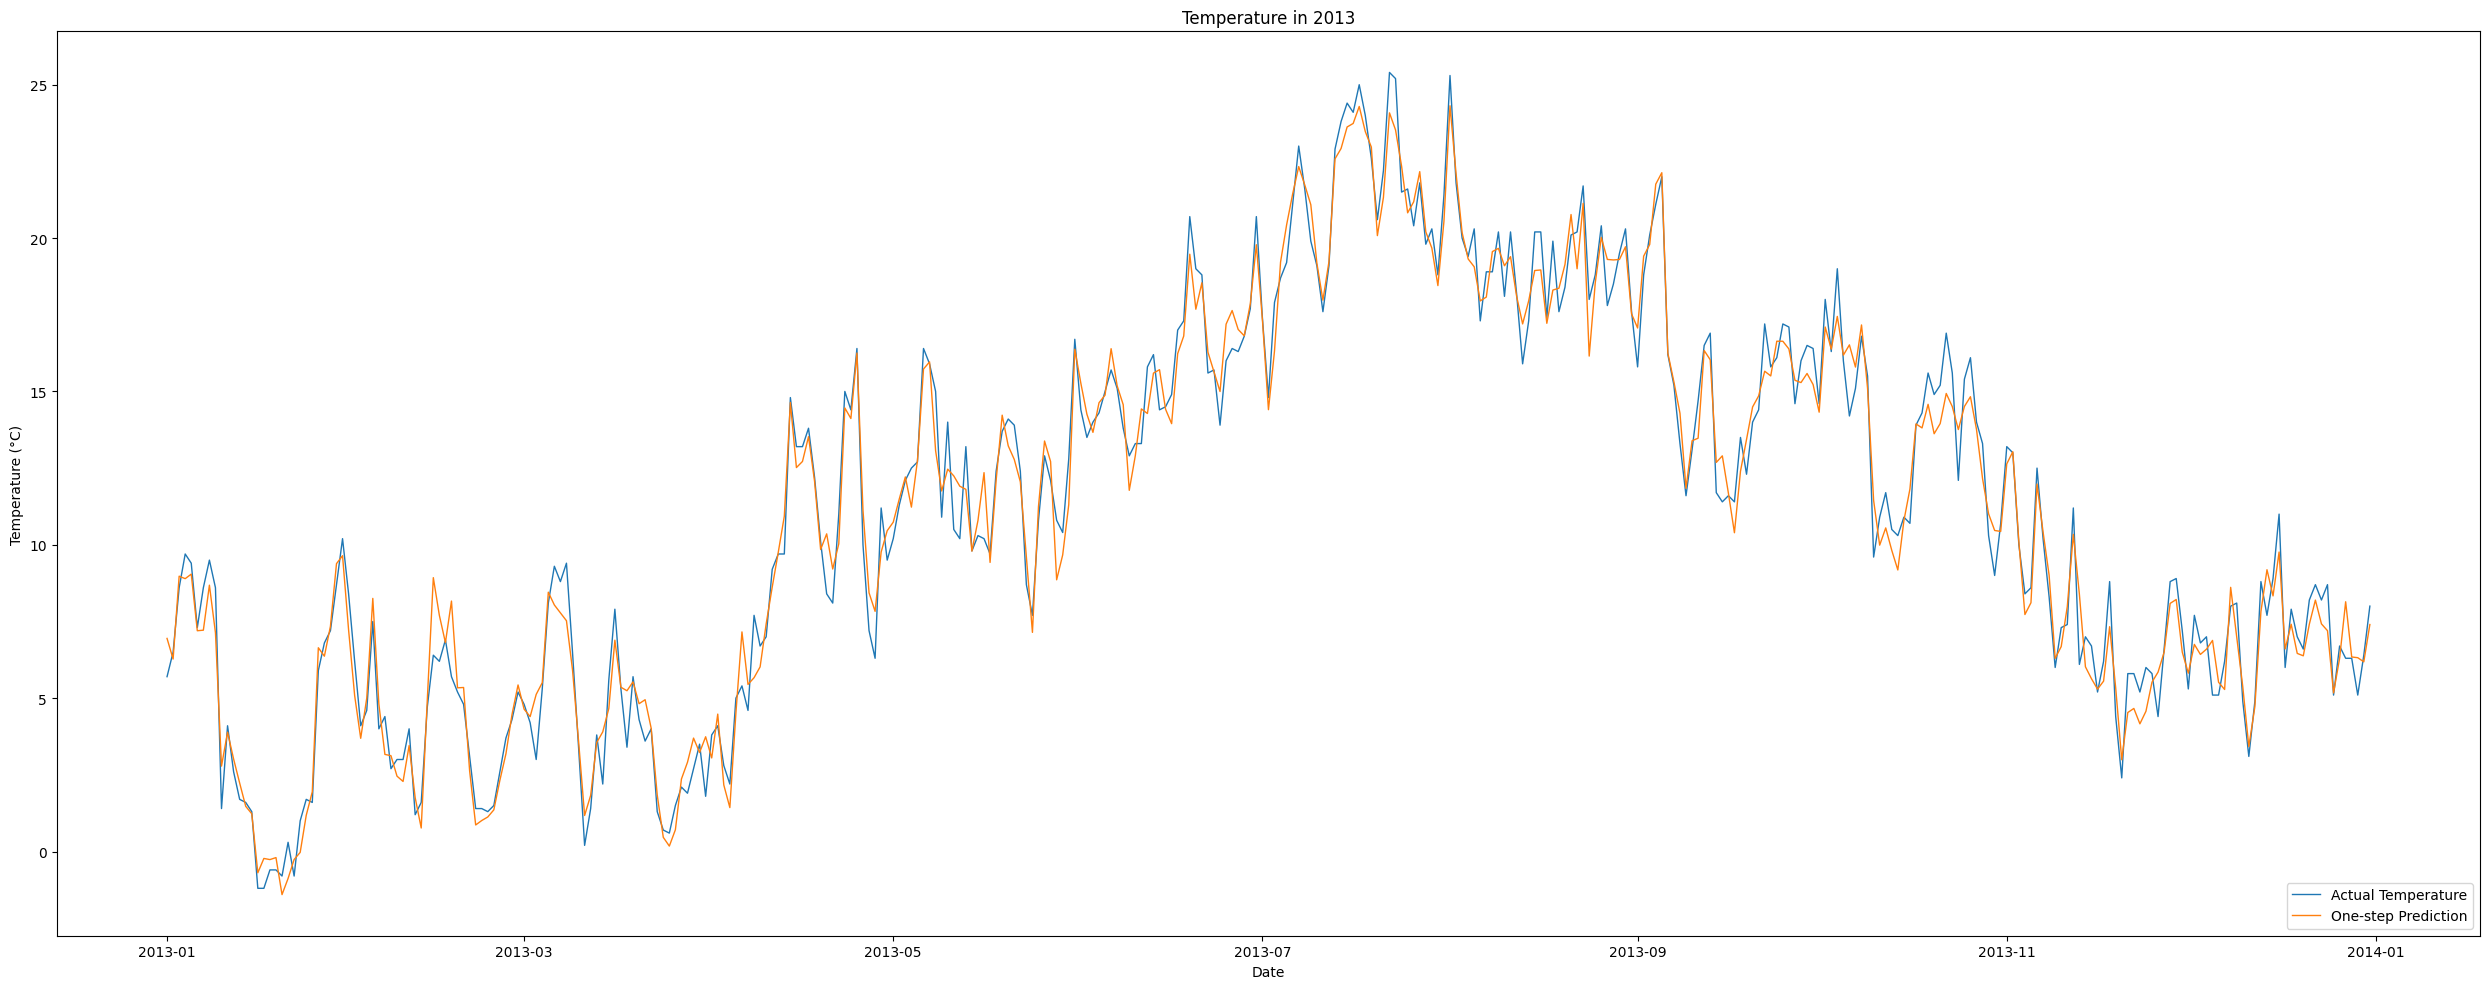

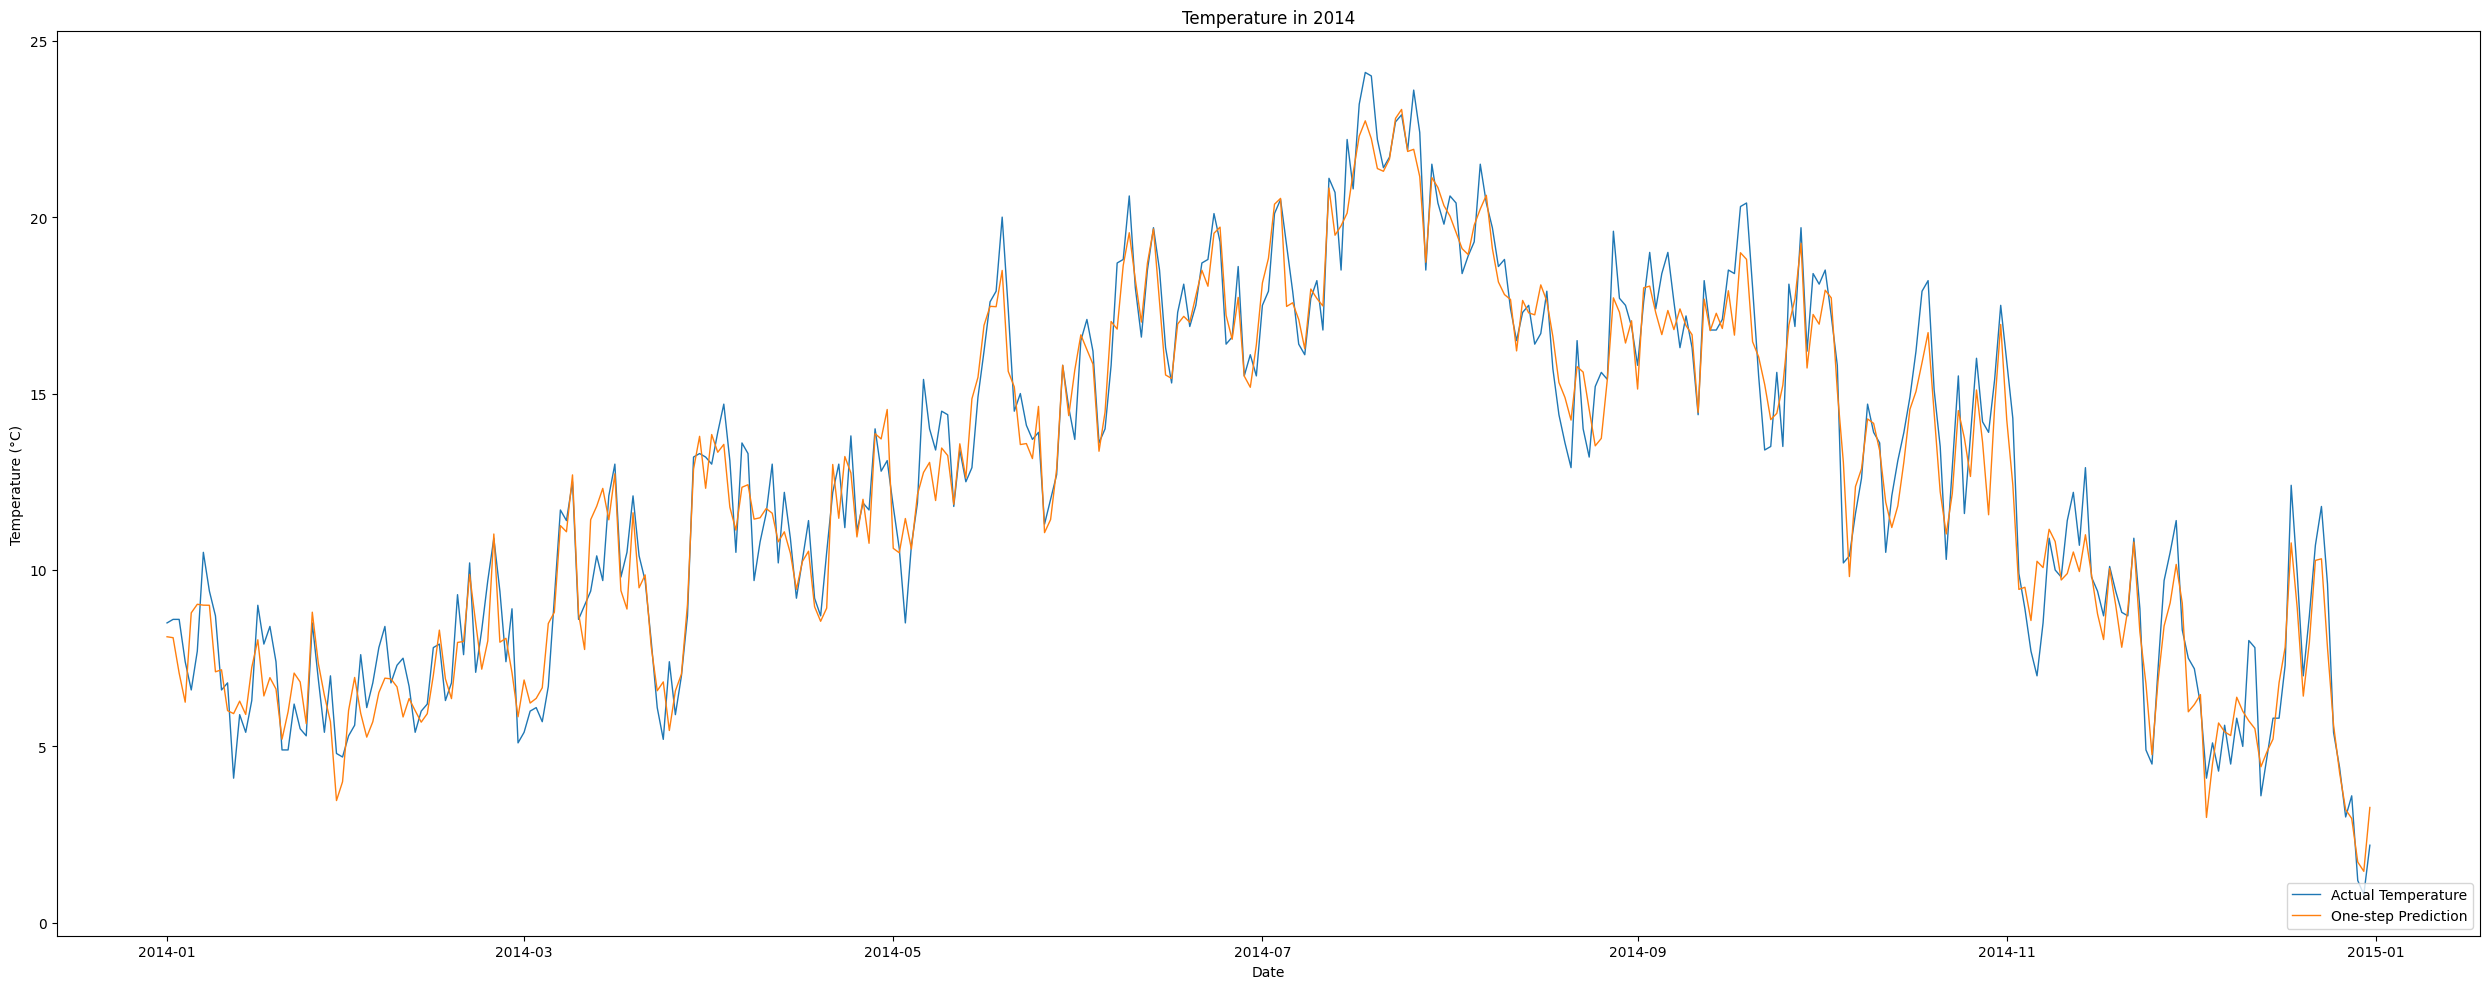

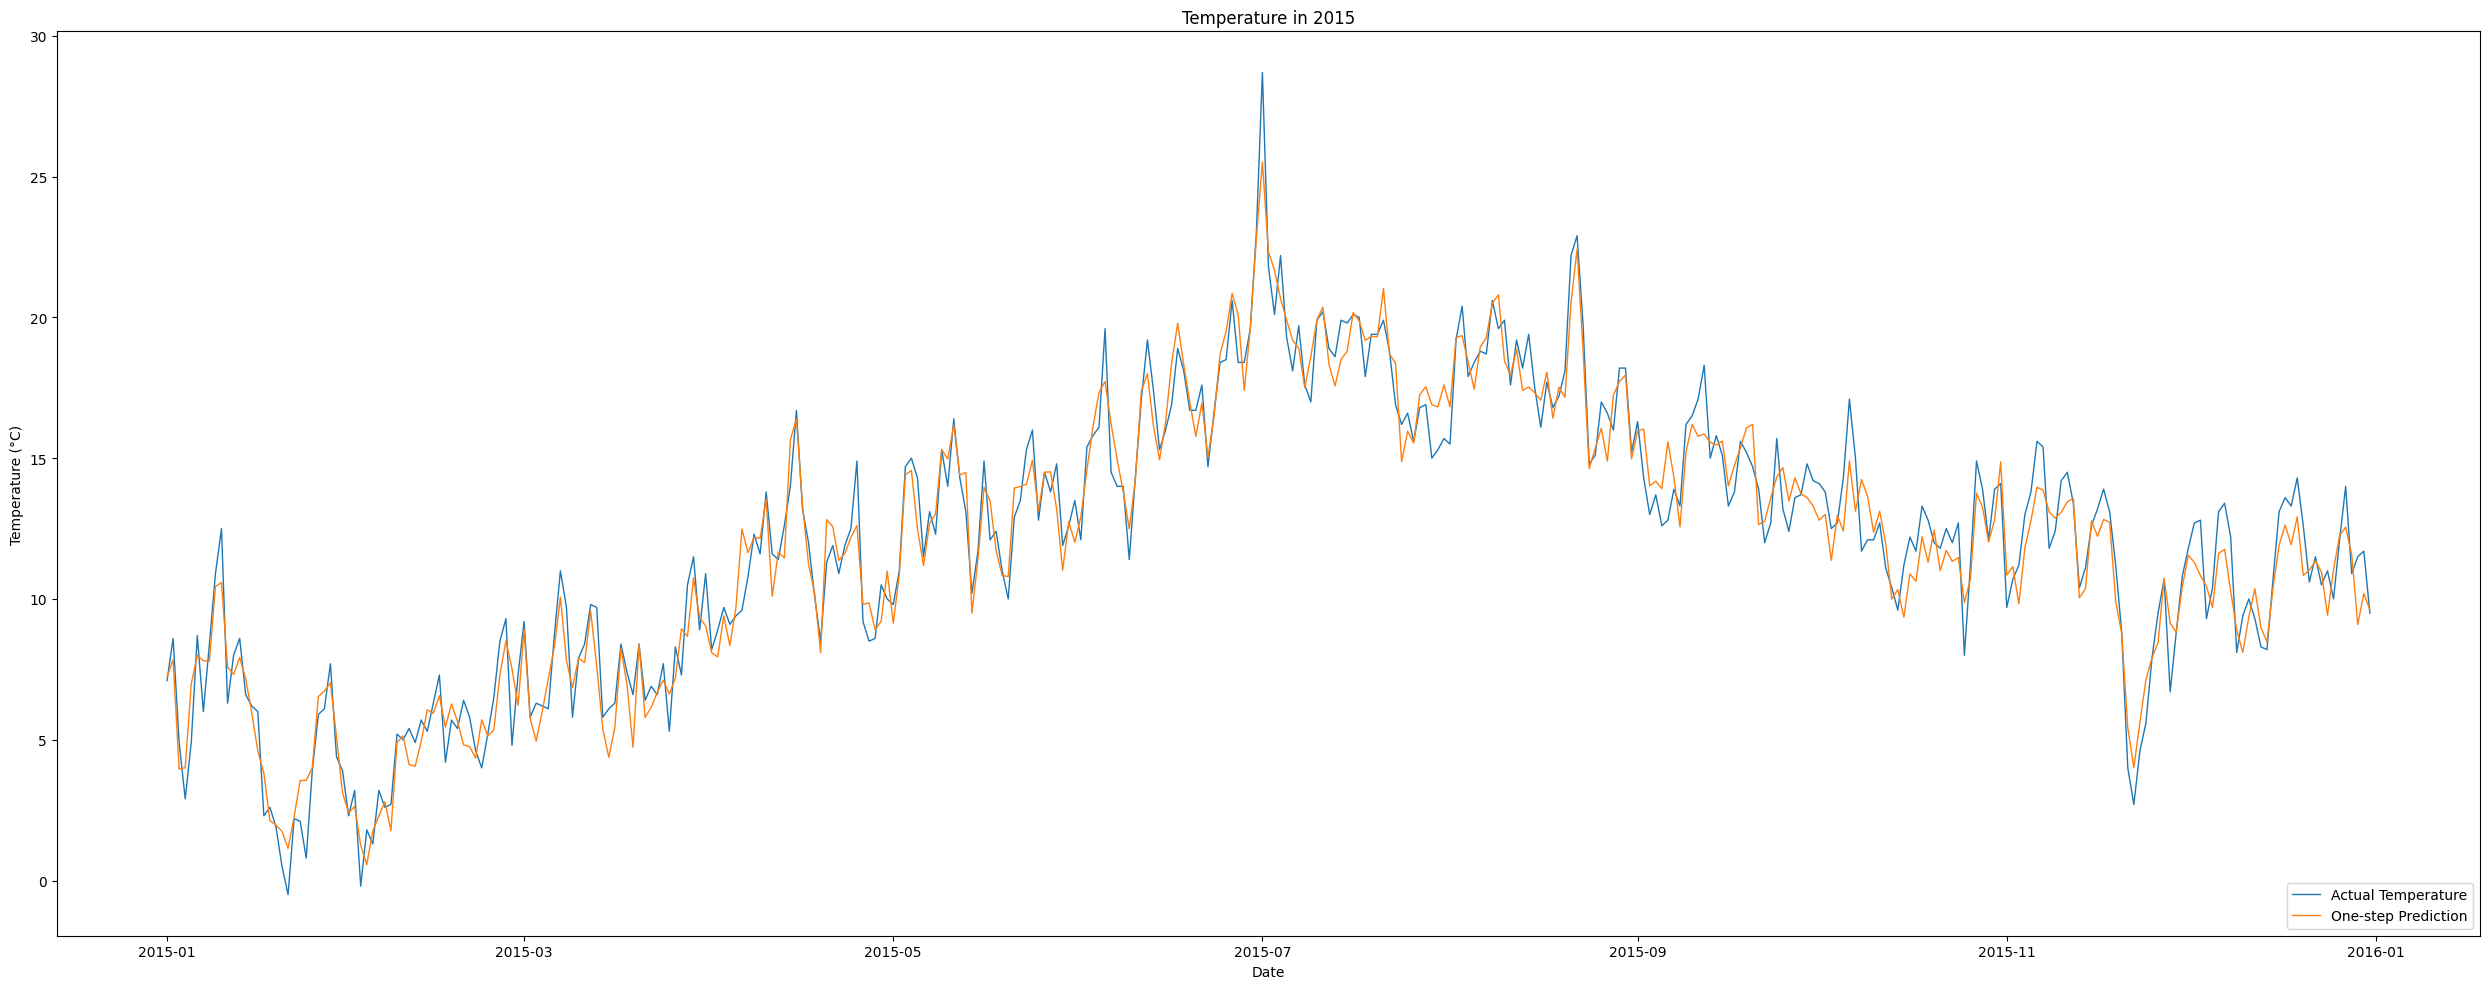

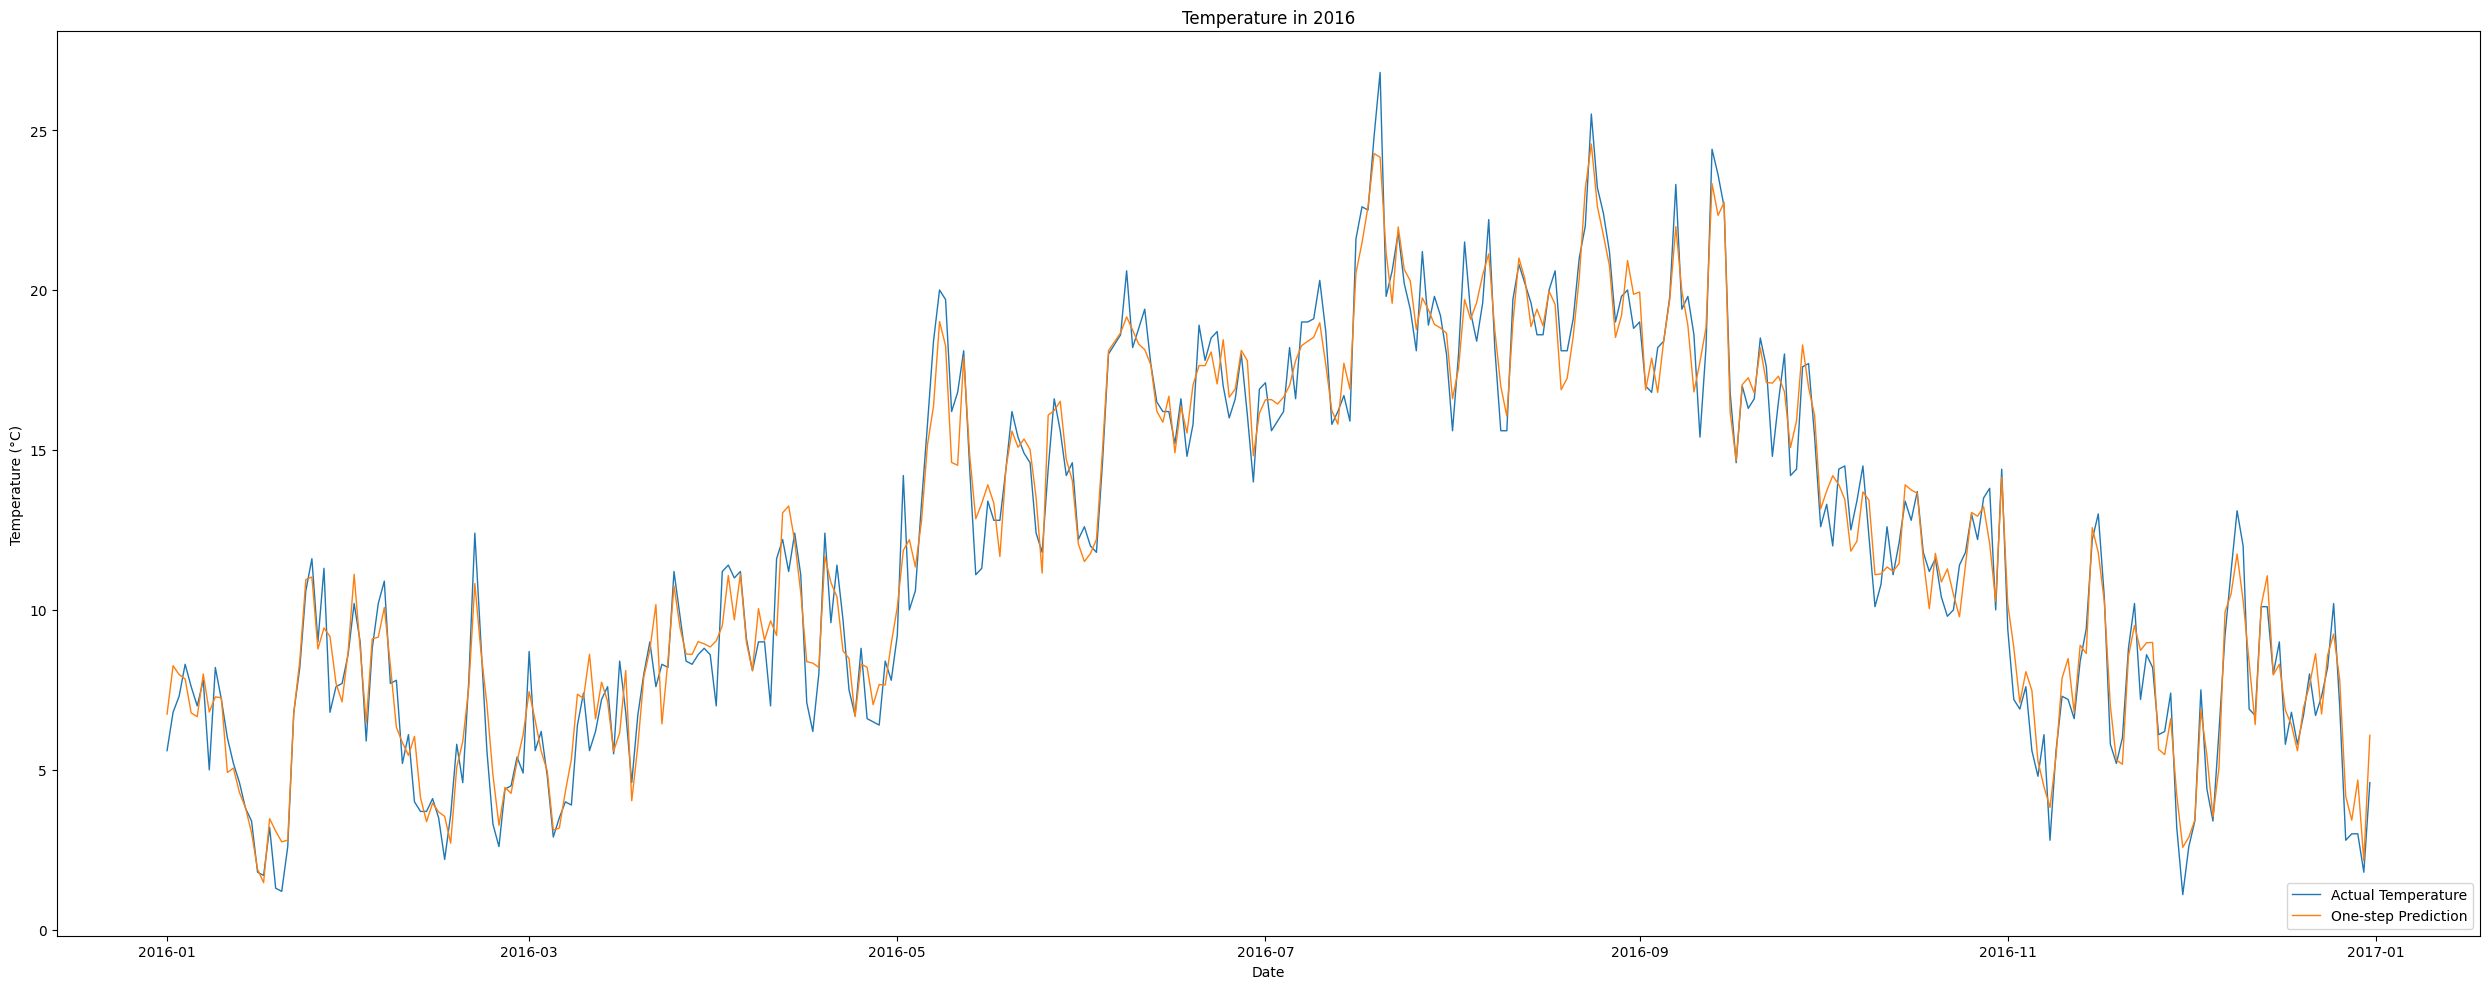

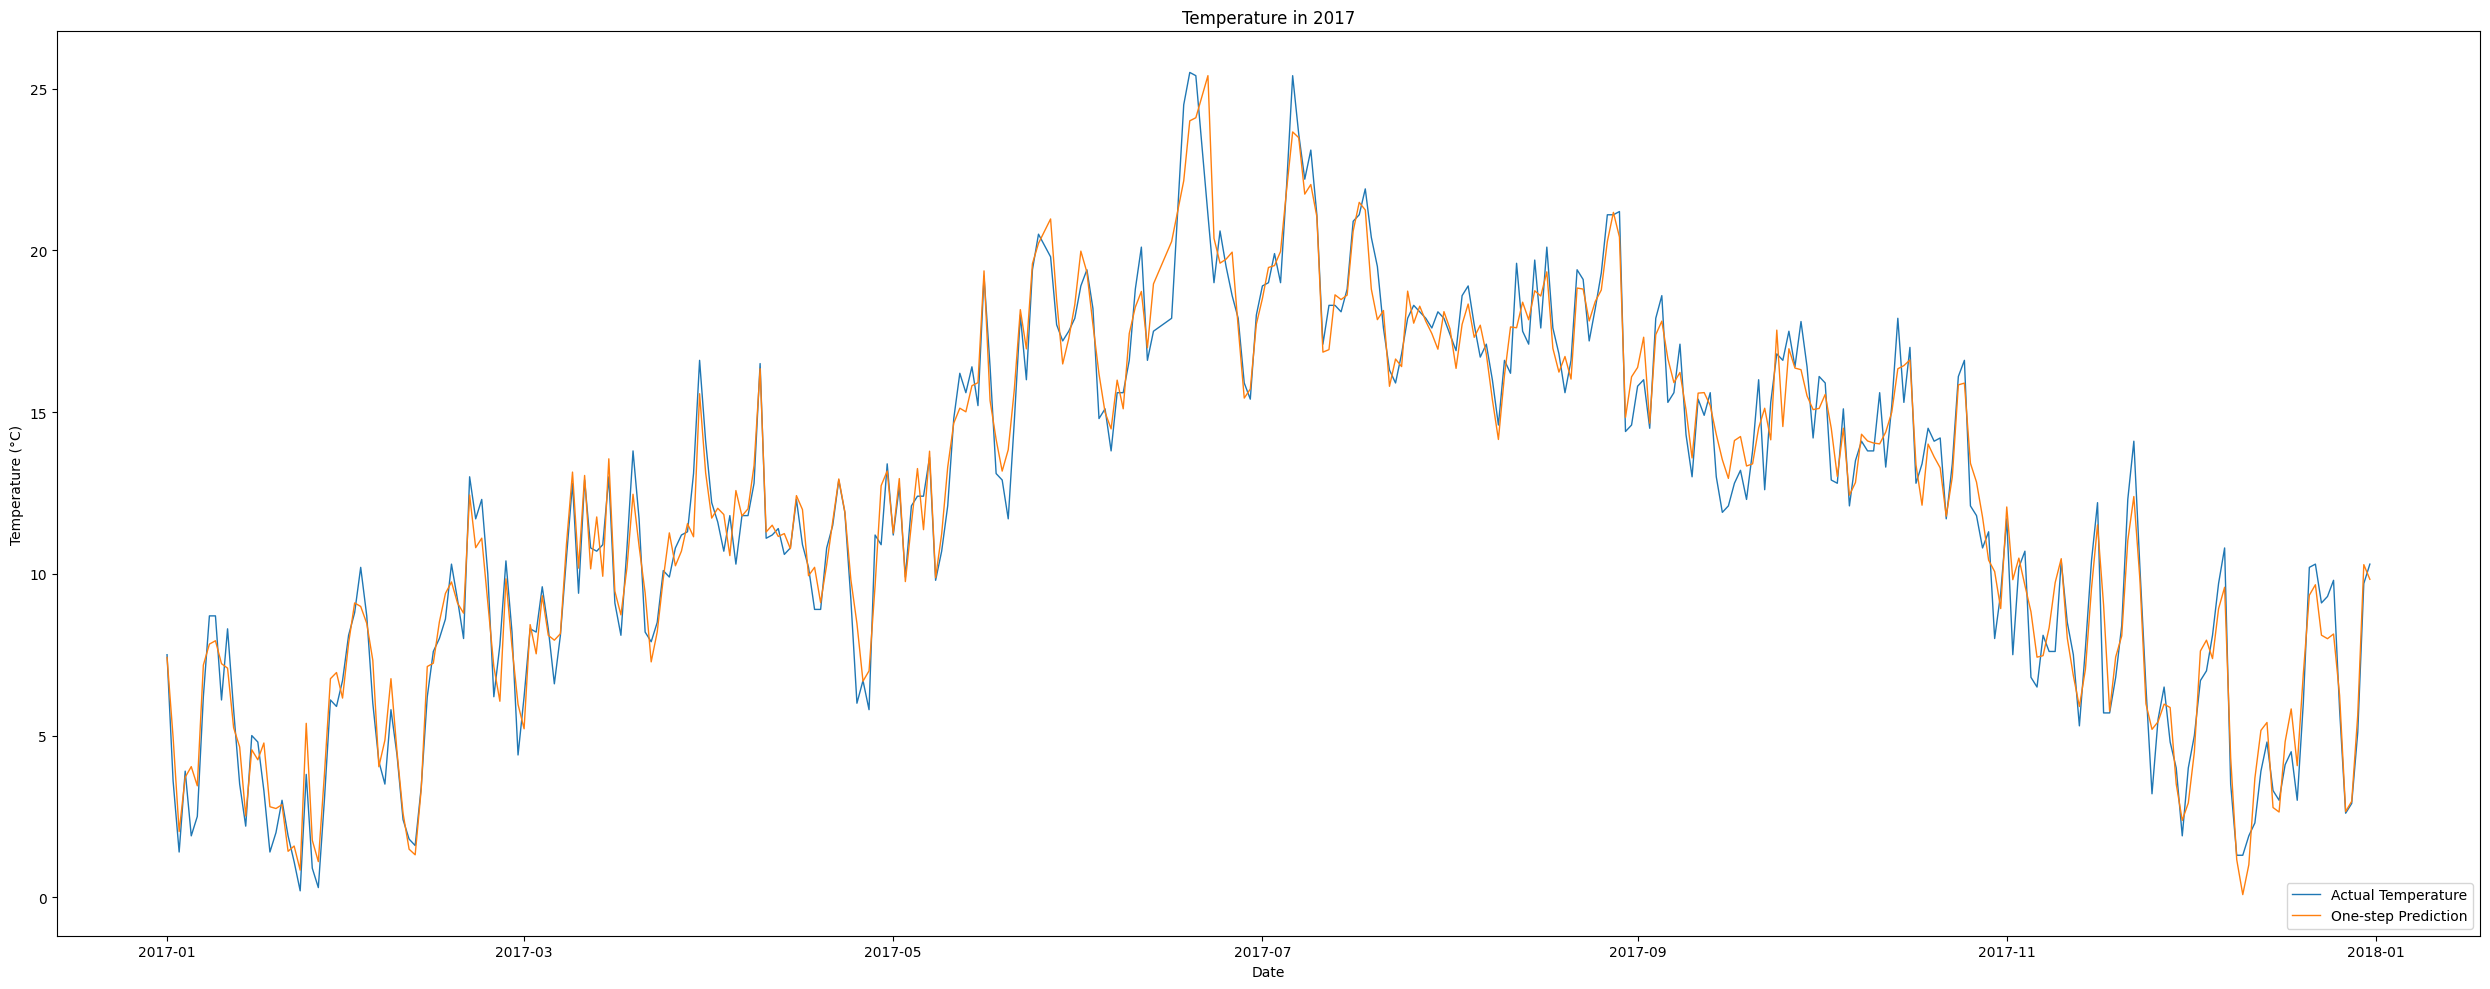

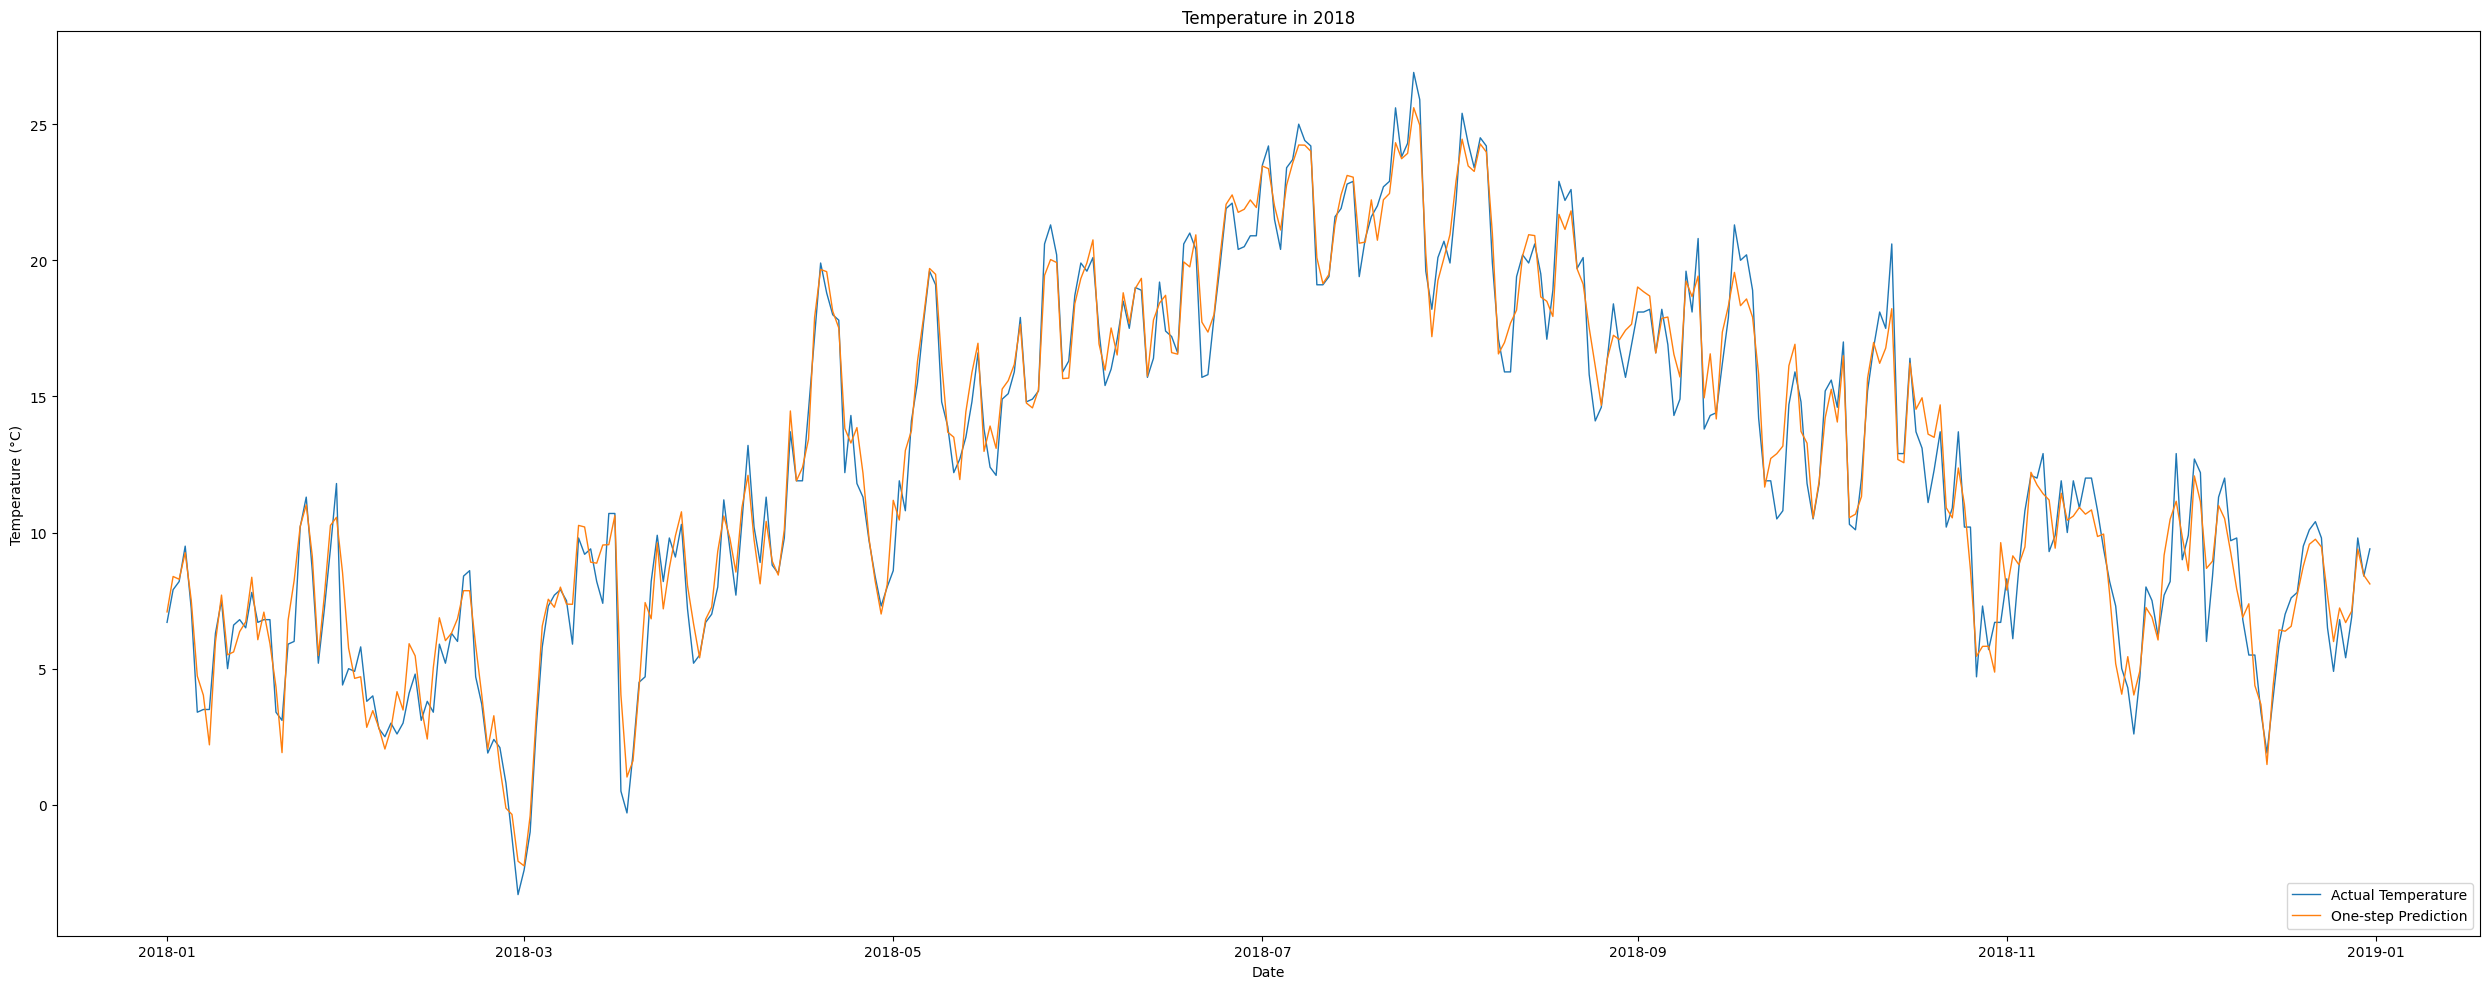

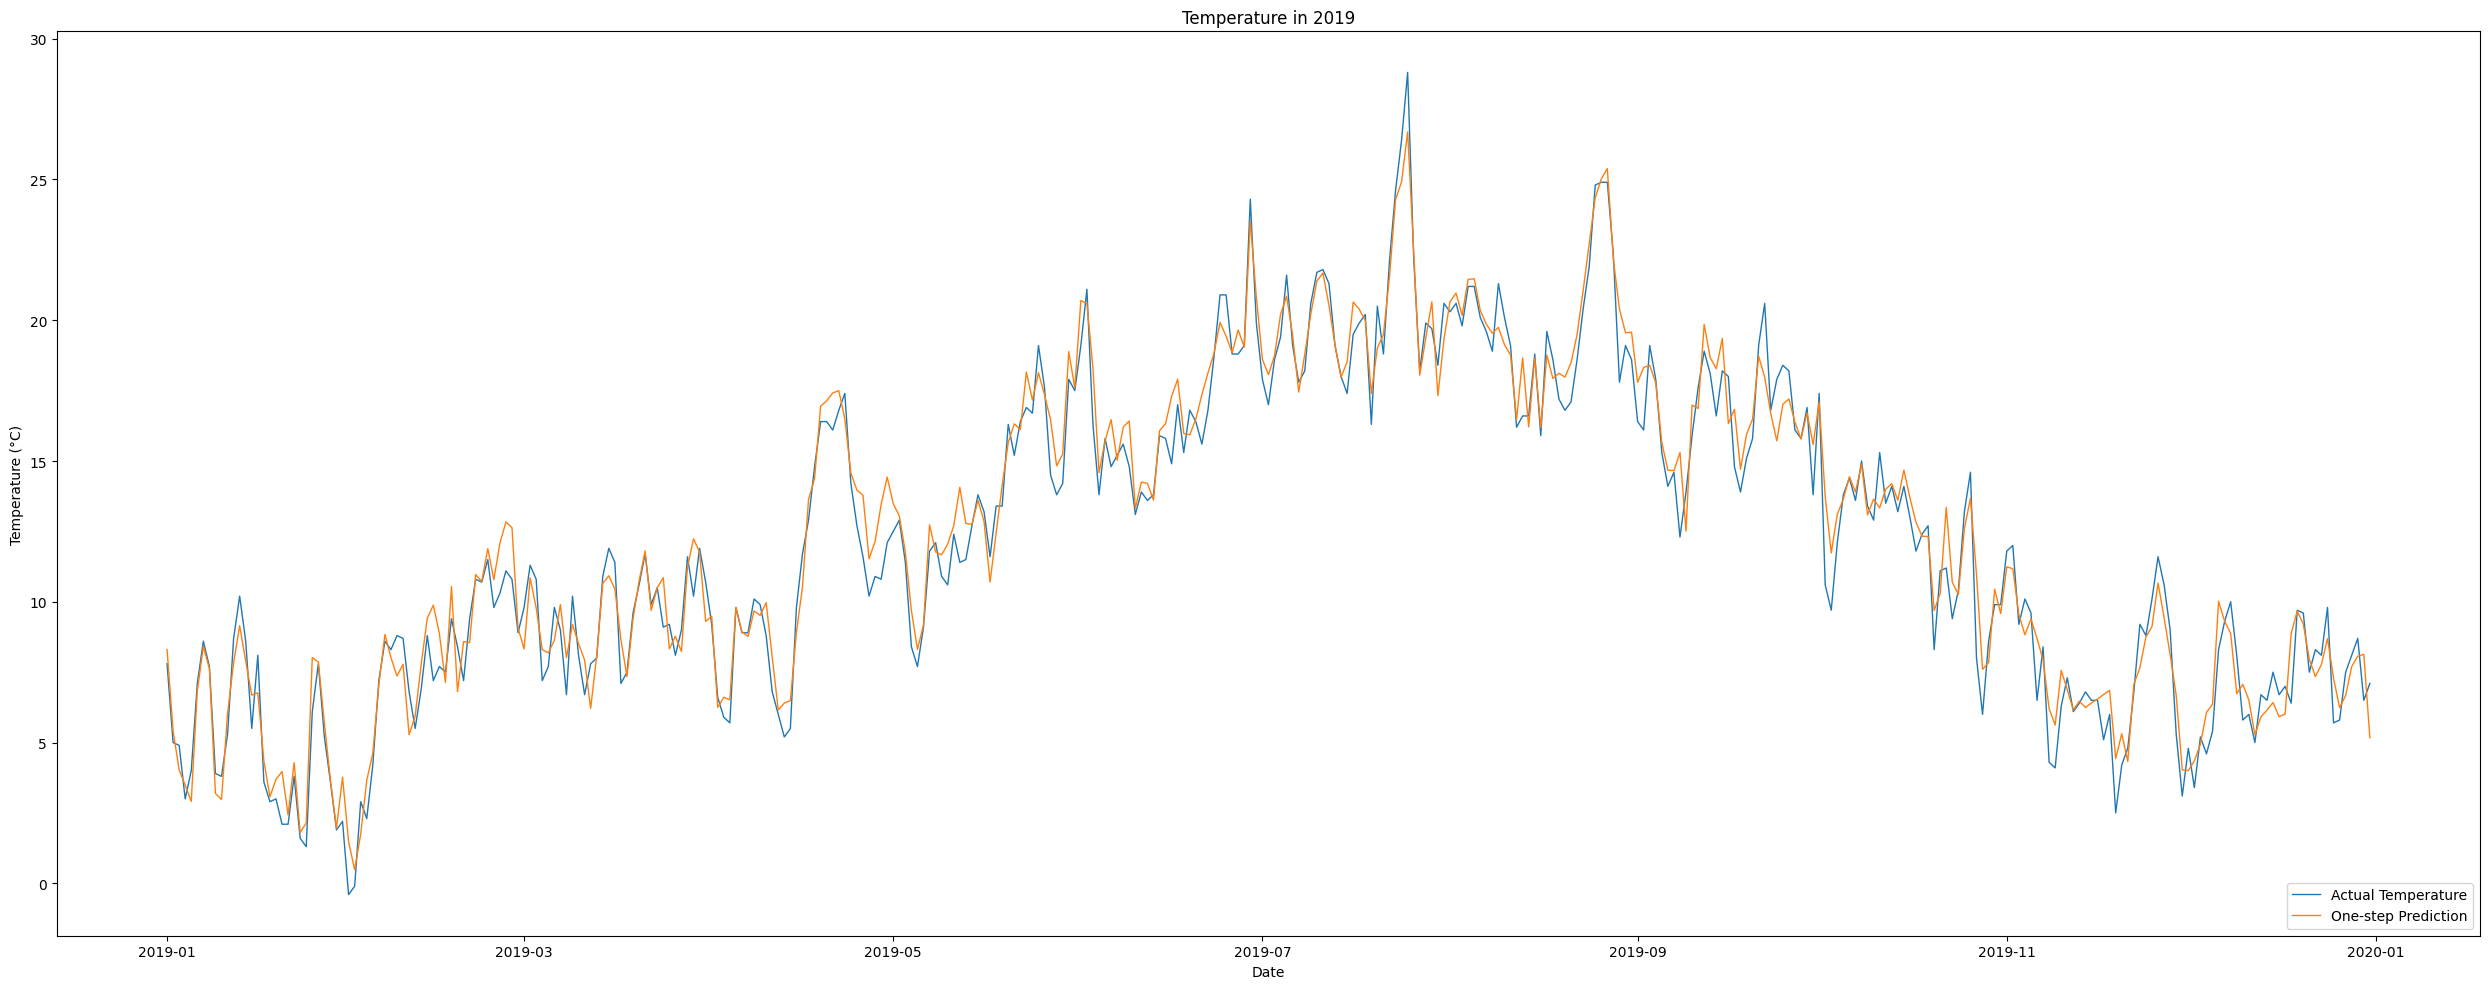

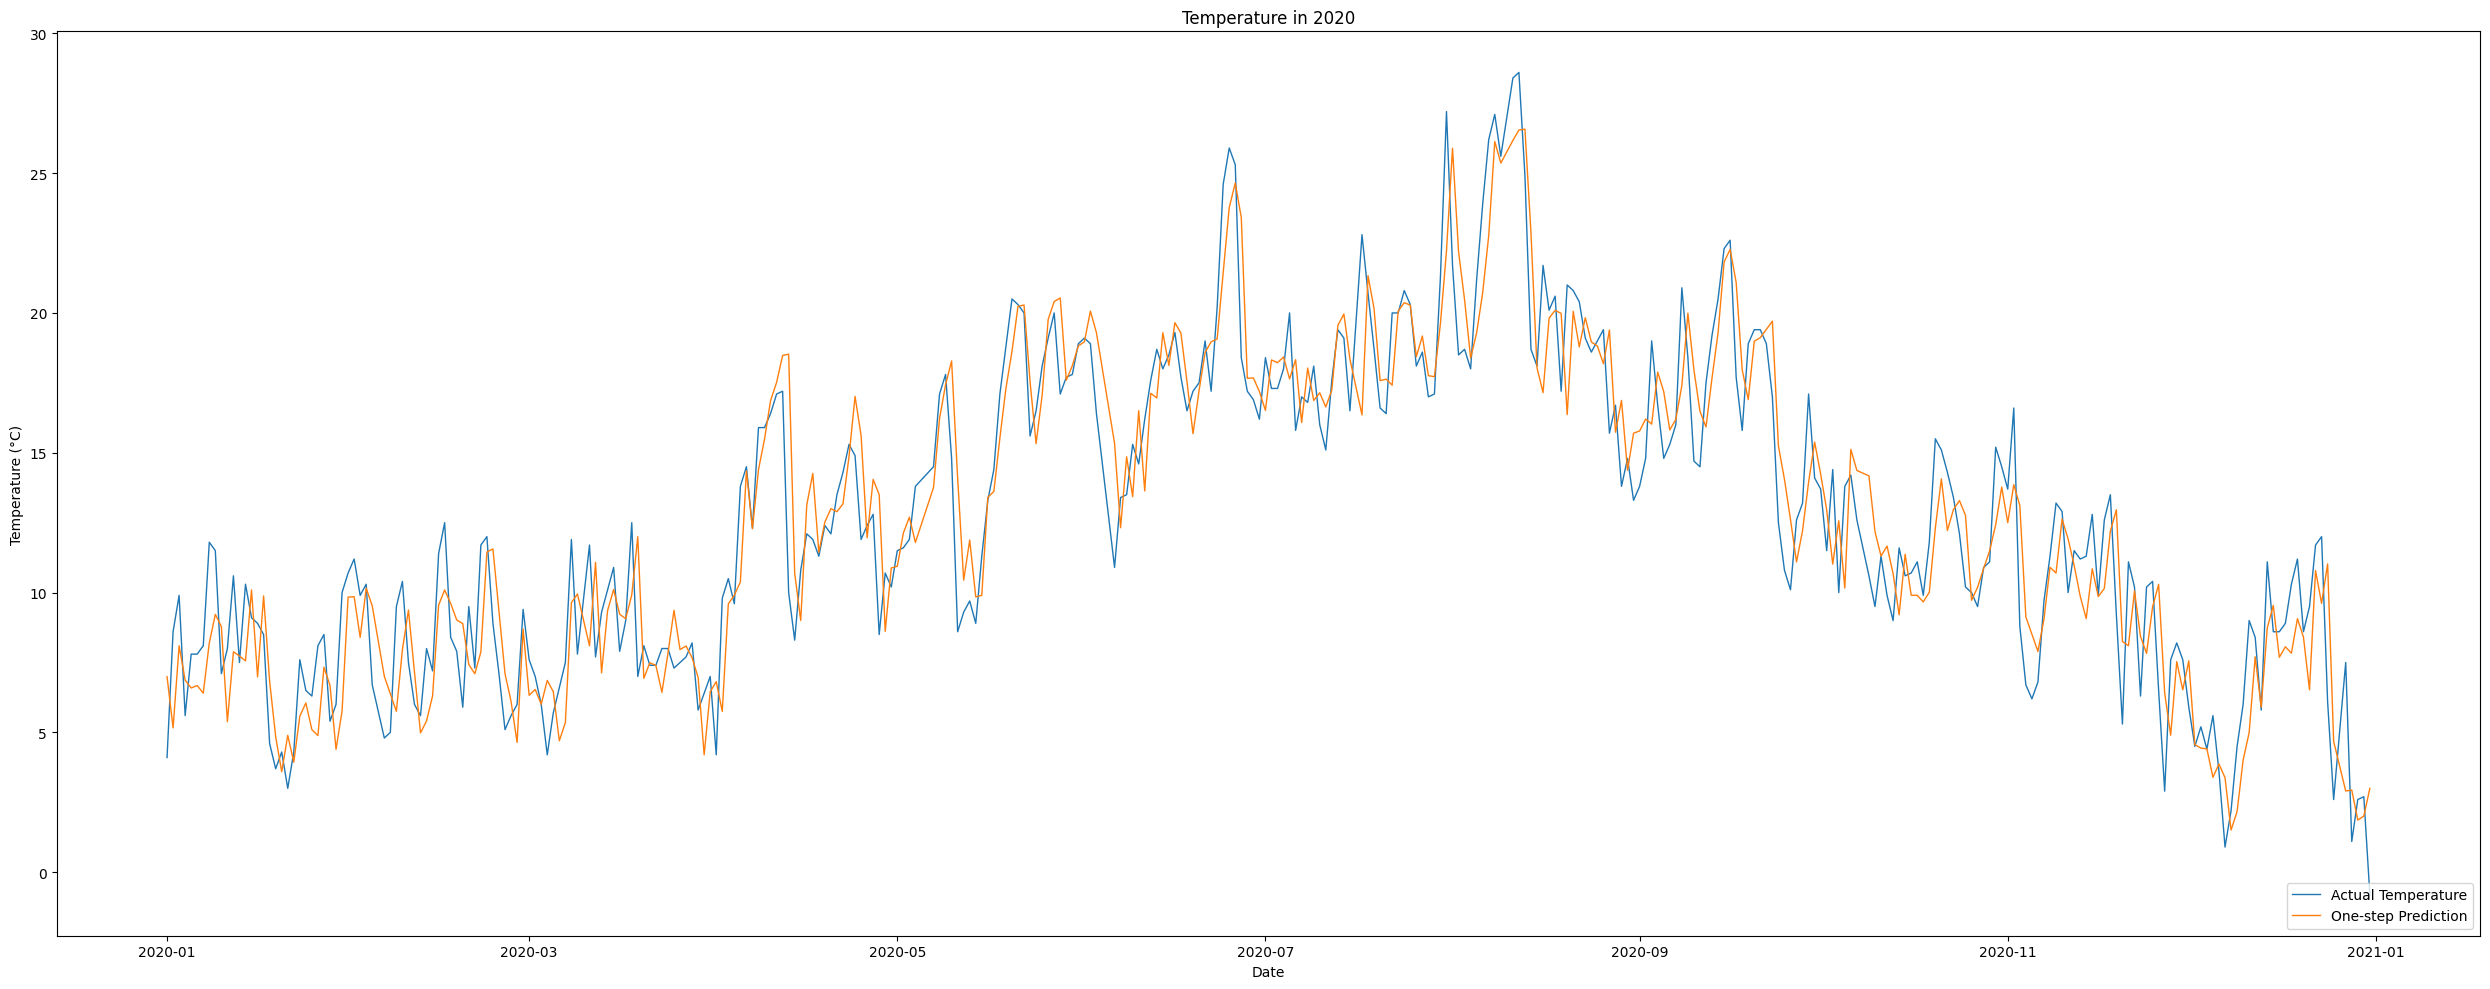

Mean square error is: 1.397


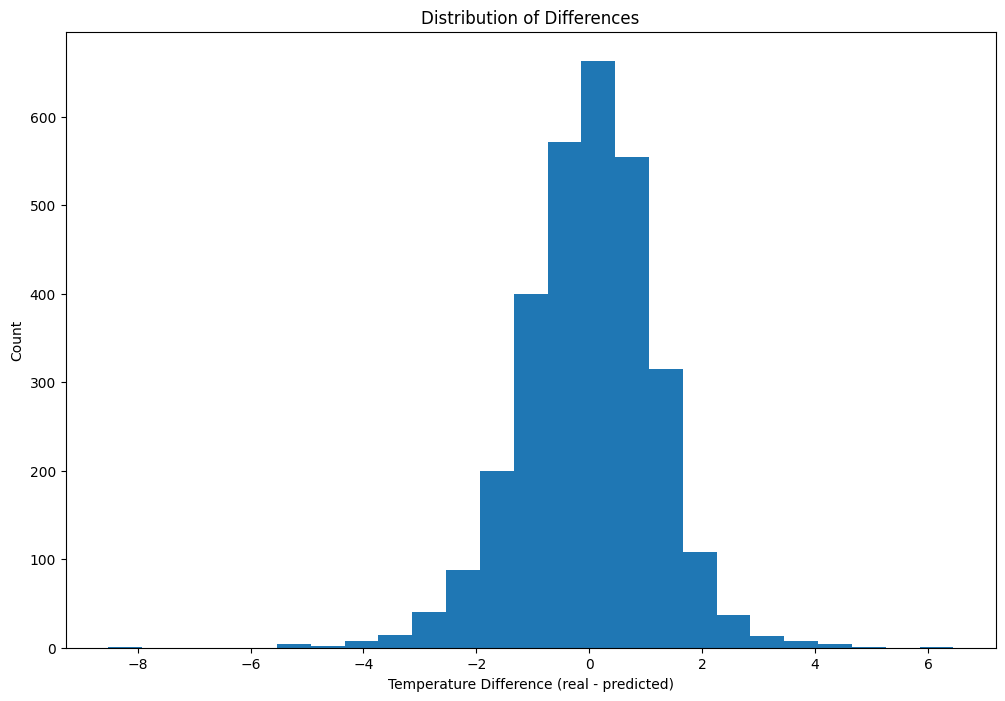

Metrics calculated - MAE: 0.999, MSE: 1.605, RMSE: 1.267
Error statistics - Mean: -0.576, Std: 1.128, Min: -3.042, Max: 1.351


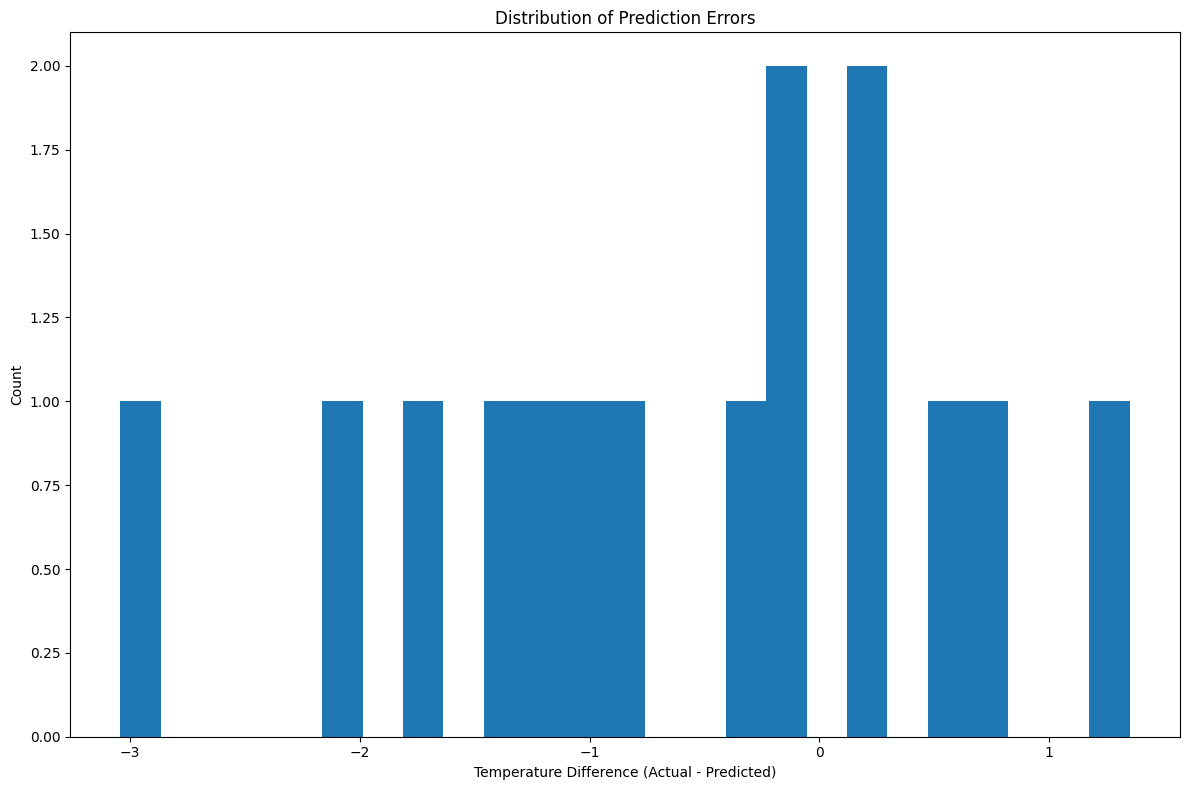


Model Performance Metrics:
MAE: 0.9994
MSE: 1.6052
RMSE: 1.2670

[CONSOLE] Operation completed.
[CONSOLE] Total operation time taken is 235.14 seconds


In [48]:
# Get original data
original_data = preprocessor.get_original_data()

# 1. Set up Display for visualizations
displayer = Display()
displayer.set_data(original_data, test_predictions, start_idx=-len(test_predictions))
displayer.set_test_data(test_target, test_predictions)

# 2. Plot training history with proper labels
displayer.plot_training_history(all_train_losses, all_test_losses)

# 3. Plot one-step predictions
displayer.plot_one_step_predictions()

# 4. Plot by year with correct label
displayer.plot_by_year(figsize=(25, 10))

# 5. Analyze LSTM error and show distribution
lstm_error_df, mse = displayer.analyze_lstm_error()

# 6. Set up Analysis for metrics
analyzer = Analysis()
analyzer.set_data(y_test[:len(all_predictions)], all_predictions)
metrics = analyzer.calculate_metrics()
errors, error_stats = analyzer.analyze_error_distribution()

# 7. Plot error histogram from Analysis
displayer.plot_error_histogram(errors)

# 8. Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

main_end_time = time.time()
print('\n[CONSOLE] Operation completed.')
print(f'[CONSOLE] Total operation time taken is {main_end_time - main_start_time:.2f} seconds')